<a href="https://colab.research.google.com/github/dbckz/crossing-the-line/blob/master/notebooks/processing_full_perspective_world_cup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import pandas as pd
import ast
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from google.colab import drive
import plotly.graph_objects as go

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set up paths
root_path = "/content/drive/MyDrive/University/Dissertation/world_cup_data"
graph_path = root_path + "/graphs"

day_paths = day_paths = [
        "/1",
        "/2"
    ]

In [4]:
# Create directory to store visualisations
try:
    os.mkdir(graph_path)
except OSError as error:
    print(error)

In [5]:
# Load data
in_tweets = pd.DataFrame()
persp = pd.DataFrame()
emojis = pd.DataFrame()
for path in day_paths:
    directory = root_path + path
    tweets_csv = directory + "/tweets.csv"
    persp_csv = directory + "/perspective_processed_tweets.csv"
    emojis_csv = directory + "/emoji.csv"

    print(f"Loading CSVs for directory {path}...")
    in_tweets = pd.concat([in_tweets, 
                           pd.read_csv(tweets_csv,
                                       usecols = [
                                                  'created_at',
                                                  'tweet_id',
                                                  'tweet_text',
                                                  'accounts_mentioned'
                                       ],
                                       dtype = {
                                          # 'created_at':
                                          'tweet_id': np.int64,
                                          'tweet_text': str,
                                          'accounts_mentioned': object
                                       },
                                       parse_dates=['created_at'])])

    persp = pd.concat([persp, pd.read_csv(persp_csv,
                                          usecols = [
                                                      'tweet_id',
                                                      'identity_attack_score',
                                                      'threat_score',
                                                      'severe_toxicity_score',
                                                      'insult_score'
                                                      
                                          ],
                                          dtype = {
                                              'tweet_id': np.int64,
                                              'identity_attack_score': np.float,
                                              'threat_score': np.float,
                                              'severe_toxicity_score': np.float,
                                              'insult_score': np.float
                                          })])

# Dedup
original_tweets_length = len(in_tweets)
original_persp_length = len(persp)
in_tweets.drop_duplicates(subset=['tweet_id'], inplace=True)
persp.drop_duplicates(subset=['tweet_id'], inplace=True)
print(f"Size of tweets dataframe: {len(in_tweets)}, having dropped {original_tweets_length - len(in_tweets)} duplicate rows")
print(f"Size of perspective dataframe: {len(persp)}, having dropped {original_persp_length - len(persp)} duplicate rows")


Loading CSVs for directory /1...


<ipython-input-5-1f09953da43b>:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'identity_attack_score': np.float,
<ipython-input-5-1f09953da43b>:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'threat_score': np.float,
<ipython-input-5-1f09953da43b>:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To s

Loading CSVs for directory /2...


<ipython-input-5-1f09953da43b>:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'identity_attack_score': np.float,
<ipython-input-5-1f09953da43b>:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'threat_score': np.float,
<ipython-input-5-1f09953da43b>:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To s

Size of tweets dataframe: 140257, having dropped 7797 duplicate rows
Size of perspective dataframe: 140257, having dropped 7799 duplicate rows


In [6]:
# Up the pandas display limits so printed dataframes aren't so truncated
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_info_rows', 100)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.precision', 9)

In [7]:
# Join tables + drop old ones!
joined_df = pd.merge(in_tweets, persp, how='inner', on='tweet_id')
del persp
del in_tweets
len(joined_df)

140257

In [8]:
# joined_df = joined_df[(joined_df['created_at'] > '2021-06-19 08:10:18+00:00') & (joined_df['created_at'] < '2021-07-17 00:00:00+00:00')]
len(joined_df)

140257

# Analysis

In [9]:
print(f"Number of tweets that Perspective could not process: {len(joined_df[joined_df['identity_attack_score'] == -1.0])}") # might need to do this later...

Number of tweets that Perspective could not process: 10334


In [10]:
# Extract players
list_of_players = ["JPickford1", "kylewalker2", "LukeShaw23", "_DeclanRice",
                   "HarryMaguire93", "JackGrealish", "JHenderson", "HKane", 
                   "sterling7", "MarcusRashford", "trippier2", "masonmount_10",
                   "PhilFoden", "ben6white", "BukayoSaka87", "BellinghamJude", 
                   "Popey1992", "AaronRamsdale98", "CallumWilson", "TrentAA", 
                   "Madders10", "ericdier", "Kalvinphillips"]


for player in list_of_players:
    print(f"Extracting {player}...")
    joined_df[player] = joined_df['accounts_mentioned'].str.contains(f"'username': '{player}'").astype(np.bool)



Extracting JPickford1...


<ipython-input-10-3382ccbf6d5f>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  joined_df[player] = joined_df['accounts_mentioned'].str.contains(f"'username': '{player}'").astype(np.bool)


Extracting kylewalker2...
Extracting LukeShaw23...
Extracting _DeclanRice...
Extracting HarryMaguire93...
Extracting JackGrealish...
Extracting JHenderson...
Extracting HKane...
Extracting sterling7...
Extracting MarcusRashford...
Extracting trippier2...
Extracting masonmount_10...
Extracting PhilFoden...
Extracting ben6white...
Extracting BukayoSaka87...
Extracting BellinghamJude...
Extracting Popey1992...
Extracting AaronRamsdale98...
Extracting CallumWilson...
Extracting TrentAA...
Extracting Madders10...
Extracting ericdier...
Extracting Kalvinphillips...


In [11]:
joined_df = joined_df[
    (joined_df["JPickford1"]) |
    (joined_df["kylewalker2"]) |
    (joined_df["LukeShaw23"]) |
    (joined_df["_DeclanRice"]) |
    (joined_df["HarryMaguire93"]) |
    (joined_df["JackGrealish"]) |
    (joined_df["JHenderson"]) |
    (joined_df["HKane"]) |
    (joined_df["sterling7"]) |
    (joined_df["MarcusRashford"]) |
    (joined_df["trippier2"]) |
    (joined_df["Kalvinphillips"]) |
    (joined_df["masonmount_10"]) |
    (joined_df["PhilFoden"]) |
    (joined_df["ben6white"]) |
    (joined_df["Popey1992"]) |
    (joined_df["AaronRamsdale98"]) |
    (joined_df["CallumWilson"]) |
    (joined_df["TrentAA"]) |
    (joined_df["Madders10"]) |
    (joined_df["ericdier"]) |
    (joined_df["BukayoSaka87"]) |
    (joined_df["BellinghamJude"])
    ]

In [13]:
print(len(joined_df))

125009


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81e8937e50>]],
      dtype=object)

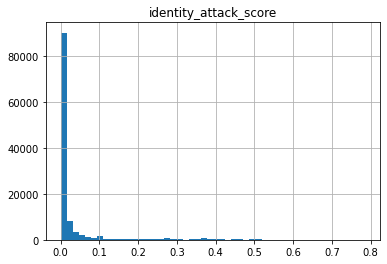

In [14]:
joined_df[joined_df['identity_attack_score'] != -1.0].hist(column = 'identity_attack_score', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81eae74100>]],
      dtype=object)

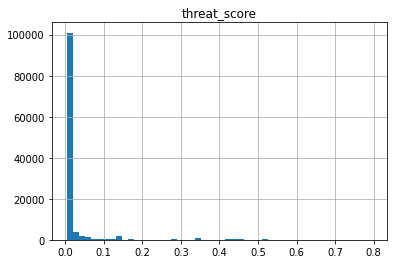

In [15]:
joined_df[joined_df['threat_score'] != -1.0].hist(column = 'threat_score', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81e83dd1f0>]],
      dtype=object)

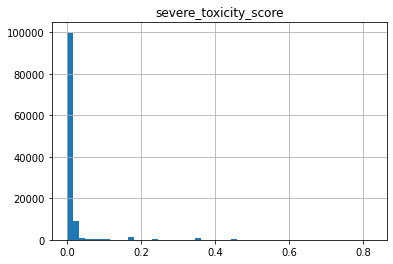

In [16]:
joined_df[joined_df['severe_toxicity_score'] != -1.0].hist(column = 'severe_toxicity_score', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81e82be340>]],
      dtype=object)

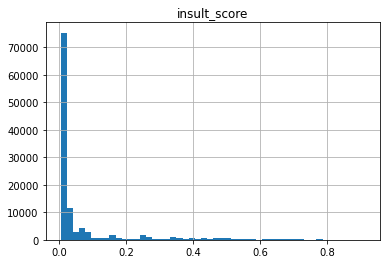

In [17]:
joined_df[joined_df['insult_score'] != -1.0].hist(column = 'insult_score', bins=50)

In [22]:
len_total = len(joined_df)
threshold = 0.5

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.9], joined_df[joined_df['threat_score'] > 0.9], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.9], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.9], how='outer', on='tweet_id')
len_90 = len(tmp)
print(f"Tweets with scores > 0.9: {len_90}, which is {(100 * (len_90 / len_total)):.2f}% of all tweets")

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.8], joined_df[joined_df['threat_score'] > 0.8], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.8], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.8], how='outer', on='tweet_id')
len_80 = len(tmp)
print(f"Tweets with scores > 0.8: {len_80}, which is {(100 * (len_80 / len_total)):.2f}% of all tweets")

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.7], joined_df[joined_df['threat_score'] > 0.7], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.7], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.7], how='outer', on='tweet_id')
len_70 = len(tmp)
print(f"Tweets with scores > 0.7: {len_70}, which is {(100 * (len_70 / len_total)):.2f}% of all tweets")

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.6], joined_df[joined_df['threat_score'] > 0.6], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.6], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.6], how='outer', on='tweet_id')
len_60 = len(tmp)
print(f"Tweets with scores > 0.6: {len_60}, which is {(100 * (len_60 / len_total)):.2f}% of all tweets")

tmp = pd.merge(joined_df[joined_df['identity_attack_score'] > 0.5], joined_df[joined_df['threat_score'] > 0.5], how='outer', on='tweet_id')
tmp = pd.merge(tmp, joined_df[joined_df['severe_toxicity_score'] > 0.5], how='outer', on='tweet_id')
# tmp = pd.merge(tmp, joined_df[joined_df['insult_score'] > 0.5], how='outer', on='tweet_id')
len_50 = len(tmp)
print(f"Tweets with scores > 0.5: {len_50}, which is {(100 * (len_50 / len_total)):.2f}% of all tweets")

joined_df['persp_over_threshold'] = (joined_df['identity_attack_score'] > threshold) | (joined_df['threat_score'] > threshold) | (joined_df['severe_toxicity_score'] > threshold)
                                                                                 
del tmp


Tweets with scores > 0.9: 0, which is 0.00% of all tweets
Tweets with scores > 0.8: 1, which is 0.00% of all tweets
Tweets with scores > 0.7: 25, which is 0.02% of all tweets
Tweets with scores > 0.6: 214, which is 0.17% of all tweets
Tweets with scores > 0.5: 1000, which is 0.80% of all tweets


In [23]:
# Maybe we don't need these cols and we can just calculate ad-hoc?
for player in list_of_players:
    joined_df[f'{player}_offensive'] = joined_df['persp_over_threshold'] & joined_df[player]

In [24]:
player_offensive_tweet_map = pd.DataFrame(columns=["username",
                                                   "tweets_received",
                                                   "offensive_tweets_received",
                                                   "percentage_offensive"
                                                   ])

i = 0
for player in list_of_players:
    off_tweets = joined_df[player + '_offensive'].sum()
    tweets = joined_df[player].sum()
    percentage = 100 * (off_tweets / tweets)
    player_offensive_tweet_map.loc[i] = player, tweets, off_tweets, percentage
    i += 1

<ipython-input-24-e47a7d3cda98>:11: RuntimeWarning: invalid value encountered in long_scalars
  percentage = 100 * (off_tweets / tweets)


In [25]:
player_offensive_tweet_map.sort_values('offensive_tweets_received', axis=0, ascending=False, inplace=True)
offensive_tweets_all = joined_df['persp_over_threshold'].sum()
offensive_tweets_top_10 = player_offensive_tweet_map['offensive_tweets_received'].head(10).sum()
top_10_proportion = offensive_tweets_top_10 / offensive_tweets_all
print(f"Total offensive tweets: {offensive_tweets_all}")
print(f"Top 10 proportion: {top_10_proportion * 100}%")

print(player_offensive_tweet_map[['username', 'offensive_tweets_received']].head(10))

Total offensive tweets: 1000
Top 10 proportion: 108.7%
          username offensive_tweets_received
7            HKane                       332
14    BukayoSaka87                       126
4   HarryMaguire93                       113
5     JackGrealish                        98
9   MarcusRashford                        96
3      _DeclanRice                        94
15  BellinghamJude                        89
8        sterling7                        52
20       Madders10                        51
2       LukeShaw23                        36


In [ ]:
# Saving a file for manual review, taken at threshold 90 - one-off ad-hoc task
# joined_df[['tweet_id', 'tweet_text']][joined_df['persp_over_threshold'] == True].to_csv("/content/drive/MyDrive/University/Dissertation/evaluation/tweets_persp.csv", index=False)

# joined_df[['tweet_id', 'tweet_text']][joined_df['persp_over_threshold'] == False].sample(1000).to_csv("/content/drive/MyDrive/University/Dissertation/evaluation/inoffensive.csv", index=False)

In [ ]:
# Write to file in prep for regression
tweets_regression_file = root_path + "/regression_tweets.csv"
joined_df.to_csv(tweets_regression_file, index=False)

# Figures

In [26]:
def create_frequency_plot(df, y_values):
    fig = go.Figure()
    for y_value in y_values:
        fig.add_trace(go.Scatter(x=df['created_at'], y=df[y_value],
                      mode='lines',
                      name=y_value))
    return fig

In [27]:
INTERVAL = pd.offsets.Minute(60)

In [29]:
# Plot all tweets frequency
df = joined_df.resample(INTERVAL, on='created_at')['tweet_id'].count().reset_index()
fig = create_frequency_plot(df, ['tweet_id'])
fig.show()

In [30]:
# Plot Sterling, Rashford, Kane tweet frequency
df = joined_df.resample(INTERVAL, on='created_at')['MarcusRashford', 'sterling7', 'HKane'].sum().reset_index()
fig = create_frequency_plot(df, ['MarcusRashford', 'sterling7', 'HKane'])
fig.show()

In [31]:
# Plot frequency of offensive tweets
df = joined_df.resample(INTERVAL, on='created_at')['persp_over_threshold'].sum().reset_index()
fig = create_frequency_plot(df, ['persp_over_threshold'])
fig.show()